In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D


In [4]:
#Define the Cassini domain boundary in polar coordinates
def cassini_boundary(theta):
  return (np.cos(3*theta)+np.sqrt(2-np.sin(3*theta)**2))**(1/3)

In [6]:
#Generate points in the Cassini domain
def generate_points(n_boundary, n_interior, n_ghost, R): # 100, 300, 400, R=3 from the paper
  theta = np.linspace(0, 2*np.pi, n_boundary, endpoint=False)
  #this divides the full circular range 0<theta<2pi into n equal angular intervals
  #once cassini_boundary(theta) is computed we then convert it into cartesian equation
  # x= r*cos(theta), y = r*sin(theta)
  boundary_points = np.array([
      cassini_boundary(theta) * np.cos(theta),
      cassini_boundary(theta) * np.sin(theta),
  ]).T

  #Generate interior points using random sampling
  interior_points = np.random.uniform(-1, 1, (n_interior, 2))
  interior_points = interior_points[np.linalg.norm(interior_points, axis=1) <= 1]

  #Generate ghost points in a circle of radius R
  angles = np.random.uniform(0, 2*np.pi, n_ghost)
  radii = np.sqrt(np.random.uniform(1, R**2, n_ghost))
  ghost_points = np.array([
      radii * np.cos(angles),
      radii * np.sin(angles),
  ]).T

  return boundary_points, interior_points, ghost_points



In [7]:
#Radial basis function (Multiquadric)
def rbf(r, c):
  return np.sqrt(1+(c*r)**2)


In [8]:
#Construct the collocation matrix
def construct_collocation_matrix(boundary, interior, ghost, c):
  points = np.vstack([boundary, interior, ghost])
  dist_matrix = cdist(points, points)
  return rbf(dist_matrix, c), points

In [9]:
#Solve the RBF system
def solve_rbf_system(A, boundary, interior, ghost, exact_sol, source_term, c):
    n_boundary = len(boundary)
    n_interior = len(interior)

    # Construct RHS (b vector)
    b = np.zeros(A.shape[0])
    b[:n_boundary] = exact_sol(boundary[:, 0], boundary[:, 1])  # Boundary conditions
    b[n_boundary:n_boundary + n_interior] = source_term(interior[:, 0], interior[:, 1])  # Source term

    # Solve the linear system
    coefficients = np.linalg.solve(A, b)
    return coefficients


In [10]:
# Evaluate the RBF approximation
def evaluate_solution(points, eval_points, coefficients, c):
    dist_matrix = cdist(eval_points, points)
    A_eval = rbf(dist_matrix, c)
    return A_eval @ coefficients

In [11]:
# Exact solution and source term
def exact_solution(x, y):
    return np.exp(x + y)

In [12]:
def source_term(x, y):
    return np.exp(x + y)  # For Poisson problem where u_xx + u_yy = f

In [13]:
# Generate data and solve
n_boundary, n_interior, n_ghost = 100, 300, 400
R, c = 3.0, 0.661

boundary_points, interior_points, ghost_points = generate_points(n_boundary, n_interior, n_ghost, R)
A, points = construct_collocation_matrix(boundary_points, interior_points, ghost_points, c)
coefficients = solve_rbf_system(A, boundary_points, interior_points, ghost_points, exact_solution, source_term, c)

In [14]:
# Evaluate the solution and compute error
eval_points = np.vstack([boundary_points, interior_points])
computed_solution = evaluate_solution(points, eval_points, coefficients, c)
true_solution = exact_solution(eval_points[:, 0], eval_points[:, 1])
error = np.abs(computed_solution - true_solution)

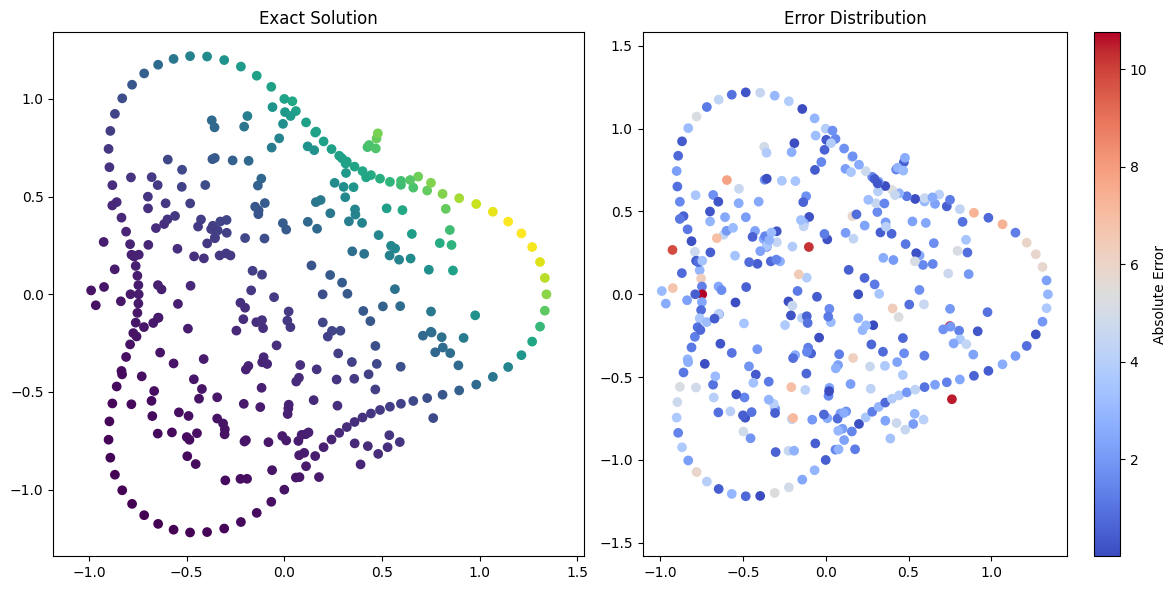

In [20]:
# Plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Exact solution
ax[0].scatter(eval_points[:, 0], eval_points[:, 1], c=true_solution, cmap='viridis')
ax[0].set_title("Exact Solution")
ax[0].axis("equal")

# Error distribution
sc = ax[1].scatter(eval_points[:, 0], eval_points[:, 1], c=error, cmap='coolwarm')
ax[1].set_title("Error Distribution")
ax[1].axis("equal")
fig.colorbar(sc, ax=ax[1], label="Absolute Error")

plt.tight_layout()
plt.show()



In [19]:
# Display max error
max_error = np.max(error)
{"Max Error": max_error}

{'Max Error': 10.7611502936156}